# Projet 7 : Implémentation d'un modèle de scoring

## <a name="C0"> Mission 1 - Élaborer le modèle de scoring<a>
## Partie 2 : Modélisation

### Problématique :
- Travailler en tant que Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
- L'entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu'un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s'appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.)

**Missions :**
<ol>   
<li> Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.</li>
<li> Analyser les features qui contribuent le plus au modèle, d'une manière générale (feature importance globale) et au niveau d'un client (feature importance locale), afin, dans un soucis de transparence, de permettre à un chargé d'études de mieux comprendre le score attribué par le modèle.</li>
<li> Mettre en production le modèle de scoring de prédiction à l'aide d'une API et réaliser une interface de test de cette API.</li>
<li> Mettre en œuvre une approche globale MLOps de bout en bout, du tracking des expérimentations à l'analyse en production du data drift.</li>
</ol>    

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature

from sklearn.metrics import (auc,roc_curve,roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,
                             make_scorer,confusion_matrix,classification_report)
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score,validation_curve,GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import mlflow.lightgbm

from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler,NearMiss
from imblearn.ensemble import BalancedRandomForestClassifier

import re
from collections import Counter

import lime
import lime.lime_tabular
import shap

import joblib
import pickle

In [2]:
data = pd.read_csv("data_train_feature_engine.csv",index_col=0)
data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+","",x))
data

,SK_ID_CURR,POS_SK_DPD_DEF_SUM,CC_DRAWING_LIMIT_RATIO_MAX,INSTAL_PAYMENT_RATIO_MEAN,POS_REMAINING_INSTALMENTS,CC_LAST_AMT_BALANCE_MEAN,CC_PAYMENT_DIV_MIN_MIN,CC_LATE_PAYMENT_VAR,NEW_DOC_KURT,PREV_SK_ID_PREV_NUNIQUE,...,AMT_ANNUITY,BURO_CREDIT_TYPE_Mortgage_MEAN,AMT_GOODS_PRICE,APPROVED_CNT_PAYMENT_MEAN,FLAG_DOCUMENT_18,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ORGANIZATION_TYPE_Construction,INSTAL_AMT_PAYMENT_MIN,BURO_AMT_CREDIT_SUM_DEBT_MEAN,TARGET
0,100002.0,0.0,0.522181,1.00000,6.0,76645.791401,1.294235,0.014808,9.0,1.0,...,24700.5,0.000000,351000.0,24.000000,0,40.500000,0,9251.775391,49156.199219,1
1,100003.0,0.0,0.522181,1.00000,1.0,76645.791401,1.294235,0.014808,9.0,3.0,...,35698.5,0.000000,1129500.0,10.000000,0,0.000000,0,6662.970215,0.000000,0
2,100004.0,0.0,0.522181,1.00000,0.0,76645.791401,1.294235,0.014808,0.0,1.0,...,6750.0,0.000000,135000.0,4.000000,0,2529.066950,0,5357.250000,0.000000,0
3,100006.0,0.0,0.522181,1.00000,3.0,0.000000,1.294235,0.000000,9.0,9.0,...,29686.5,0.014232,297000.0,18.000000,0,2529.066950,0,2482.919922,160390.363995,0
4,100007.0,0.0,0.522181,1.00000,14.0,76645.791401,1.294235,0.014808,9.0,6.0,...,21865.5,0.000000,513000.0,20.671875,0,2529.066950,0,0.180000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,456251.0,0.0,0.522181,1.00000,0.0,76645.791401,1.294235,0.014808,9.0,1.0,...,27558.0,0.014232,225000.0,8.000000,0,2529.066950,0,6605.910156,160390.363995,0
307502,456252.0,0.0,0.522181,1.00000,0.0,76645.791401,1.294235,0.014808,9.0,1.0,...,12001.5,0.014232,225000.0,6.000000,0,2529.066950,0,10046.879883,160390.363995,0
307503,456253.0,5.0,0.522181,1.00000,0.0,76645.791401,1.294235,0.014808,9.0,2.0,...,29979.0,0.000000,585000.0,5.000000,0,2529.066950,0,27.270000,448958.250000,0
307504,456254.0,0.0,0.522181,1.00000,12.0,76645.791401,1.294235,0.014808,9.0,2.0,...,20205.0,0.000000,319500.0,15.000000,0,2529.066950,0,2296.439941,0.000000,1


In [7]:
data.isna().sum().sum()

np.int64(0)

In [4]:
# Define features and target variable
X = data.drop(columns=["TARGET"])
y = data["TARGET"]

# Split data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

print(f"X_train shape : {X_train.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"X_val shape : {X_val.shape}")
print(f"y_val shape : {y_val.shape}")

X_train shape : (246004, 136)
y_train shape : (246004,)
X_val shape : (61502, 136)
y_val shape : (61502,)


In [5]:
# StandardScaler object
scaler = StandardScaler()

# X_train scaled
X_train_scaled= scaler.fit_transform(X_train)

# X_val transformed
X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled,columns=X_val.columns)

In [6]:
# RandomUnderSampler object
under_sampler = RandomUnderSampler(random_state=42)

# fit predictor and target variable
X_under_sampled,y_under_sampled=under_sampler.fit_resample(X_train_scaled,y_train)

print("Original dataset shape :", Counter(y_train))
print("Resampled dataset shape :", Counter(y_under_sampled))

Original dataset shape : Counter({0: 226145, 1: 19859})
Resampled dataset shape : Counter({0: 19859, 1: 19859})


In [7]:
# SMOTE object
smote = SMOTE(random_state=42)

# fit predictor and target variable
X_smote,y_smote=smote.fit_resample(X_train_scaled,y_train)

print("Original dataset shape :", Counter(y_train))
print("Resampled dataset shape :", Counter(y_smote))

Original dataset shape : Counter({0: 226145, 1: 19859})
Resampled dataset shape : Counter({0: 226145, 1: 226145})


## Définition des métrics

In [8]:
def model_eval_score(model,Xval,yval):
    yval_pred = model.predict(Xval)
    # Confusion matrix on the validation data
    conf_mat = confusion_matrix(yval, yval_pred)
    print("Confusion matrix :\n",conf_mat)
    # Classification report
    print("Classification report :\n",classification_report(yval,yval_pred))
    print()
    print(f"Accuracy : {accuracy_score(yval, yval_pred):.3}")
    print(f"Precision : {precision_score(yval, yval_pred):.3}")
    print(f"Recall : {recall_score(yval, yval_pred):.3}")
    print(f"F1 score : {f1_score(yval, yval_pred):.3}")
    print(f"ROCAUC score : {roc_auc_score(yval, yval_pred):.3}")
    print(f"Fowlkes_Mallows score : {fowlkes_mallows_score(yval, yval_pred):.3}")
    print()

def model_eval(model, Xval, yval):
    model_eval_score(model, Xval, yval)
    
    yval_proba=model.predict_proba(Xval)[:,1]
    # calculate ROC curve
    fpr,tpr,thresholds=roc_curve(yval, yval_proba)
    roc_auc=auc(fpr,tpr) # AUROC represents the likelihood of your model distinguishing observations from two classes.

    plt.title("Roc curve",fontweight="bold")
    plt.plot(fpr, tpr,"b",label="AUC = %0.2f" % roc_auc)
    plt.legend(loc="best")
    plt.plot([0,1],[0,1],"r--")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel("True positive rate",fontweight="bold")
    plt.xlabel("False positive rate",fontweight="bold")
    
    plt.show()

**Score métier**

La banque cherche à identifier les demandeurs ne pouvant pas rembourser un prêt et les nomme comme "positif" au défaut. Le défaut de remboursement est donc considéré comme l'évènement positif : Classe 1. La capacité à rembourser est ici l'évènement "négatif" : Classe 0.
- TP (True Positives) : La prédiction est positive et la valeur réelle est positive : Crédit non accordé ET client en défaut de payement.
- TN (True Negatives) : La prédiction est négative et la valeur réelle est négative : Crédit accordé ET client en capacité de payer.
- FP (False Positive) : La prédiction est positive mais la valeur réelle est négative : Crédit non accordé MAIS client en capacité de payer ==> bon client prédit mauvais ==> manque à gagner en marge / perte d'intêret ==> moins risqué.
- FN (False Negative) : La prédiction est négative mais la valeur réelle est positive : Crédit accordé MAIS client en défaut de payement ==> mauvais client prédit bon client ==> perte en capital.

L'idée est de pallier au déséquilibre du coût métier entre un faux négatif et un faux positif en maximisant le taux de vrais positifs(en minimisant donc le taux de faux négatifs).
- De ce fait, je vais créer un score métier (minimisation du coût d'erreur de prédiction des FN et FP) pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres en optimisant le seuil qui détermine, à partir d'une probabilité, la classe 0 ou 1(un “predict” suppose un seuil à 0.5 qui n'est pas forcément l'optimum).

||Predicted Negatif||Predicted Positif|
|--|--|--|--|
|Negatif|TN||FP|
|Positif|FN||TP|

In [9]:
def metric_metier(tn,fp,fn,tp,coef_tn,coef_fp,coef_fn,coef_tp):
    # Total gain
    total_gain = coef_tn*tn + coef_fp*fp + coef_fn*fn + coef_tp*tp
    # Maximum gain
    max_gain = (tn+fp)*coef_tn + (tp+fn)*coef_tp
    # Minimum gain
    min_gain = (tn+fp)*coef_fp + (tp+fn)*coef_fn
    # normalisation min-max  
    scaled_gain = (total_gain-min_gain)/(max_gain-min_gain)
    return scaled_gain

# I. Essais de modélisation

# 1. Baseline : classificateur Dummy de comparaison avec le hasard

Confusion matrix :
 [[56537     0]
 [ 4965     0]]
Classification report :
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.46      0.50      0.48     61502
weighted avg       0.85      0.92      0.88     61502


Accuracy : 0.919
Precision : 0.0
Recall : 0.0
F1 score : 0.0
ROCAUC score : 0.5
Fowlkes_Mallows score : 0.923



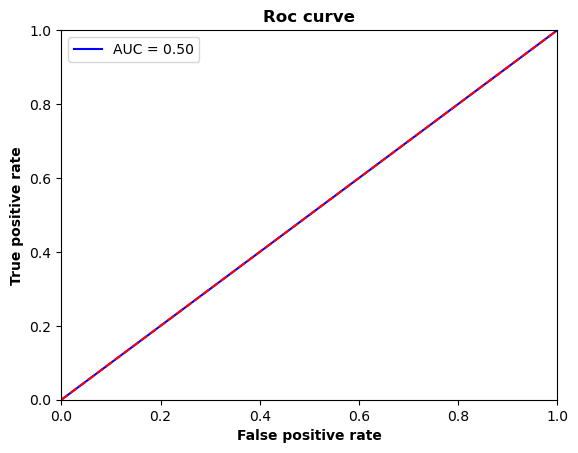

In [10]:
# Dummy classifier object
dummy_cls = DummyClassifier()
dummy_cls.fit(X_train, y_train)

# Model evaluation
model_eval(dummy_cls, X_val, y_val)

In [11]:
y_val_pred = dummy_cls.predict(X_val)
# Confusion matrix on the validation data
conf_mat = confusion_matrix(y_val,y_val_pred)

tn = float(conf_mat[0][0])
fn = float(conf_mat[1][0])
tp = float(conf_mat[1][1])
fp = float(conf_mat[0][1])

# Afféctation subjective des coéfficients du score métier : fn = 10*fp  
score_metier = round(metric_metier(tn,fp,fn,tp,1,-10,-100,0),3)
score_metier

0.556

# 2. Régression logistique 

## 2.1. Régression logistique simple

Confusion matrix :
 [[56524    13]
 [ 4965     0]]
Classification report :
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.46      0.50      0.48     61502
weighted avg       0.85      0.92      0.88     61502


Accuracy : 0.919
Precision : 0.0
Recall : 0.0
F1 score : 0.0
ROCAUC score : 0.5
Fowlkes_Mallows score : 0.923



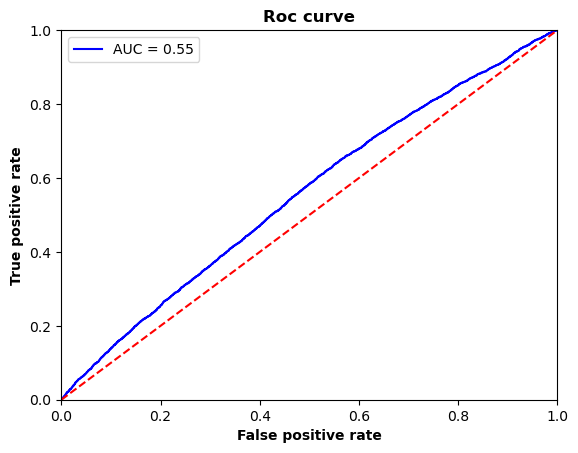

In [12]:
# LogisticRegression object
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Model evaluation
model_eval(lr, X_val, y_val)

In [13]:
y_val_pred = lr.predict(X_val)
# Confusion matrix on the validation data
conf_mat = confusion_matrix(y_val,y_val_pred)

tn = float(conf_mat[0][0])
fn = float(conf_mat[1][0])
tp = float(conf_mat[1][1])
fp = float(conf_mat[0][1])

# Afféctation subjective des coéfficients du score métier : fn = 10*fp
score_metier = round(metric_metier(tn,fp,fn,tp,1,-10,-100,0),3)
score_metier

0.556

## 2.2. Régression logistique simple avec mise à l'échelle des données

Confusion matrix :
 [[56442    95]
 [ 4859   106]]
Classification report :
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.53      0.02      0.04      4965

    accuracy                           0.92     61502
   macro avg       0.72      0.51      0.50     61502
weighted avg       0.89      0.92      0.88     61502


Accuracy : 0.919
Precision : 0.527
Recall : 0.0213
F1 score : 0.041
ROCAUC score : 0.51
Fowlkes_Mallows score : 0.922



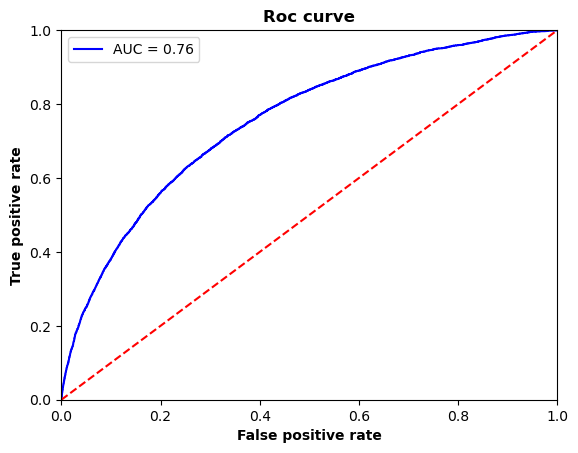

In [14]:
# LogisticRegression object
lr_scale = LogisticRegression(random_state=42)
lr_scale.fit(X_train_scaled,y_train)

# Model evaluation
model_eval(lr_scale,X_val_scaled,y_val)

In [15]:
y_val_pred = lr_scale.predict(X_val_scaled)
# Confusion matrix on the validation data
conf_mat = confusion_matrix(y_val,y_val_pred)

tn = float(conf_mat[0][0])
fn = float(conf_mat[1][0])
tp = float(conf_mat[1][1])
fp = float(conf_mat[0][1])

# Afféctation subjective des coéfficients du score métier : fn = 10*fp
score_metier = round(metric_metier(tn,fp,fn,tp,1,-10,-100,0),3)
score_metier

0.565

## 2.3. Mise à l'échelle et approches de re-échantillonnage

### 2.3.1. Sous échantillonnage

#### 2.3.1.1 Sous-échantillonnage avec NearMiss

- NearMiss est une technique de sous-échantillonnage. Au lieu de rééchantillonner la classe minoritaire, l'utilisation d'une distance rendra la classe majoritaire égale à la classe minoritaire.

In [16]:
# NearMiss object
nearmiss = NearMiss()

# fit predictor and target variable
X_nearMiss,y_nearMiss = nearmiss.fit_resample(X_train_scaled,y_train)

print("Original dataset shape :", Counter(y_train))
print("Resample dataset shape :", Counter(y_nearMiss))

Original dataset shape : Counter({0: 226145, 1: 19859})
Resample dataset shape : Counter({0: 19859, 1: 19859})


Confusion matrix :
 [[15972 40565]
 [  895  4070]]
Classification report :
               precision    recall  f1-score   support

           0       0.95      0.28      0.44     56537
           1       0.09      0.82      0.16      4965

    accuracy                           0.33     61502
   macro avg       0.52      0.55      0.30     61502
weighted avg       0.88      0.33      0.41     61502


Accuracy : 0.326
Precision : 0.0912
Recall : 0.82
F1 score : 0.164
ROCAUC score : 0.551
Fowlkes_Mallows score : 0.708



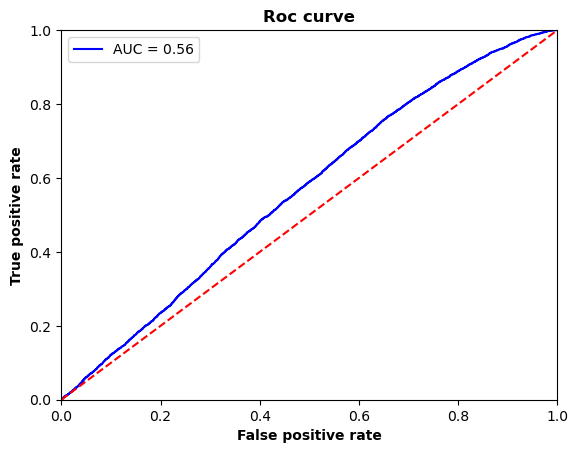

In [17]:
# LogisticRegression object
lr_nearmiss = LogisticRegression()
lr_nearmiss.fit(X_nearMiss,y_nearMiss)

# Model evaluation
model_eval(lr_nearmiss,X_val_scaled,y_val)

In [18]:
y_val_pred = lr_nearmiss.predict(X_val_scaled)
# Confusion matrix on the validation data
conf_mat = confusion_matrix(y_val,y_val_pred)

tn = float(conf_mat[0][0])
fn = float(conf_mat[1][0])
tp = float(conf_mat[1][1])
fp = float(conf_mat[0][1])

# Afféctation subjective des coéfficients du score métier : fn = 10*fp
score_metier = round(metric_metier(tn,fp,fn,tp,1,-10,-100,0),3)
score_metier

0.521

#### 2.3.1.2 Sous-échantillonnage avec RandomUnderSampler

- RandomUnderSampler est un moyen rapide et simple d'équilibrer les données en sélectionnant aléatoirement un sous-ensemble de données pour les classes ciblées. Sous-échantillonnage de la classe majoritaire en sélectionnant aléatoirement des échantillons avec ou sans remise.

Confusion matrix :
 [[39513 17024]
 [ 1578  3387]]
Classification report :
               precision    recall  f1-score   support

           0       0.96      0.70      0.81     56537
           1       0.17      0.68      0.27      4965

    accuracy                           0.70     61502
   macro avg       0.56      0.69      0.54     61502
weighted avg       0.90      0.70      0.77     61502


Accuracy : 0.698
Precision : 0.166
Recall : 0.682
F1 score : 0.267
ROCAUC score : 0.691
Fowlkes_Mallows score : 0.716



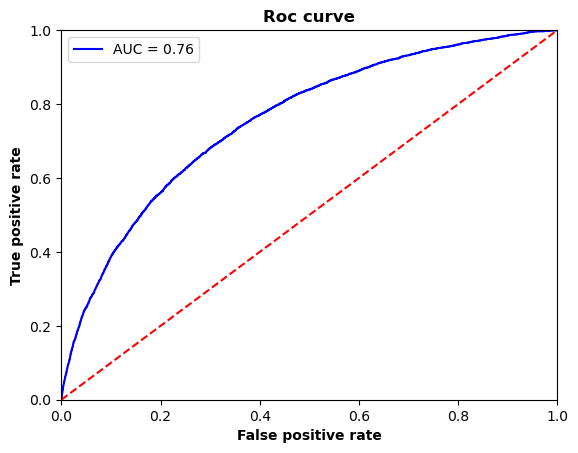

In [19]:
# LogisticRegression object
lr_scale_under_sampling = LogisticRegression()
lr_scale_under_sampling.fit(X_under_sampled,y_under_sampled)

# Model evaluation
model_eval(lr_scale_under_sampling, X_val_scaled, y_val)

In [20]:
y_val_pred = lr_scale_under_sampling.predict(X_val_scaled)
# Confusion matrix on the validation data
conf_mat = confusion_matrix(y_val,y_val_pred)

tn = float(conf_mat[0][0])
fn = float(conf_mat[1][0])
tp = float(conf_mat[1][1])
fp = float(conf_mat[0][1])

# Afféctation subjective des coéfficients du score métier : fn = 10*fp
score_metier = round(metric_metier(tn,fp,fn,tp,1,-10,-100,0),3)
score_metier

0.691

### 2.3.2. Sur-échantillonnage : SMOTE (Synthetic Minority Oversampling Technique)

- Cette technique génère des données synthétiques pour la classe minoritaire. SMOTE fonctionne en choisissant au hasard un point de la classe minoritaire et en calculant les k-voisins les plus proches pour ce point. Les points synthétiques sont ajoutés entre le point choisi et ses voisins.

Confusion matrix :
 [[39831 16706]
 [ 1675  3290]]
Classification report :
               precision    recall  f1-score   support

           0       0.96      0.70      0.81     56537
           1       0.16      0.66      0.26      4965

    accuracy                           0.70     61502
   macro avg       0.56      0.68      0.54     61502
weighted avg       0.90      0.70      0.77     61502


Accuracy : 0.701
Precision : 0.165
Recall : 0.663
F1 score : 0.264
ROCAUC score : 0.684
Fowlkes_Mallows score : 0.719



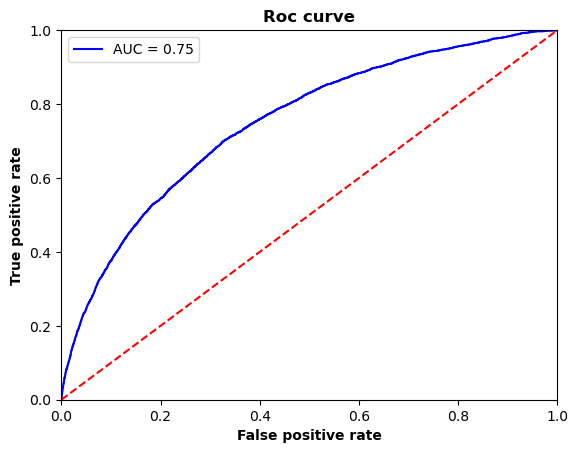

In [21]:
# LogisticRegression object
lr_smote = LogisticRegression(random_state=42)
lr_smote.fit(X_smote,y_smote)

# Model evaluation
model_eval(lr_smote, X_val_scaled, y_val)

In [22]:
y_val_pred = lr_smote.predict(X_val_scaled)
# Confusion matrix on the validation data
conf_mat = confusion_matrix(y_val,y_val_pred)

tn = float(conf_mat[0][0])
fn = float(conf_mat[1][0])
tp = float(conf_mat[1][1])
fp = float(conf_mat[0][1])

# Afféctation subjective des coéfficients du score métier : fn = 10*fp
score_metier = round(metric_metier(tn,fp,fn,tp,1,-10,-100,0),3)
score_metier

0.686

## 2.4. LogisticRegression avec GridSearchCV

In [38]:
%%time
# GridSearchCV avec Lr
parameters = {
                'penalty':['l1','l2'], 
                'C':[0.5,1,1.5,10]
}
lr_grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42),param_grid=parameters,scoring="roc_auc",cv=5)
lr_grid_search.fit(X_train_scaled,y_train)   

CPU times: total: 8min 14s
Wall time: 2min 7s


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.5, 1, 1.5, 10], 'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [39]:
# Print best parameters and best score
print("Best Parameters:", lr_grid_search.best_params_)
print("Best Score:", lr_grid_search.best_score_)

Best Parameters: {'C': 0.5, 'penalty': 'l2'}
Best Score: 0.7586662557155366


In [40]:
# print winning set of hyperparameters
from pprint import pprint
pprint(lr_grid_search.best_estimator_.get_params())

{'C': 0.5,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


Confusion matrix :
 [[56442    95]
 [ 4860   105]]
Classification report :
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.53      0.02      0.04      4965

    accuracy                           0.92     61502
   macro avg       0.72      0.51      0.50     61502
weighted avg       0.89      0.92      0.88     61502


Accuracy : 0.919
Precision : 0.525
Recall : 0.0211
F1 score : 0.0407
ROCAUC score : 0.51
Fowlkes_Mallows score : 0.922



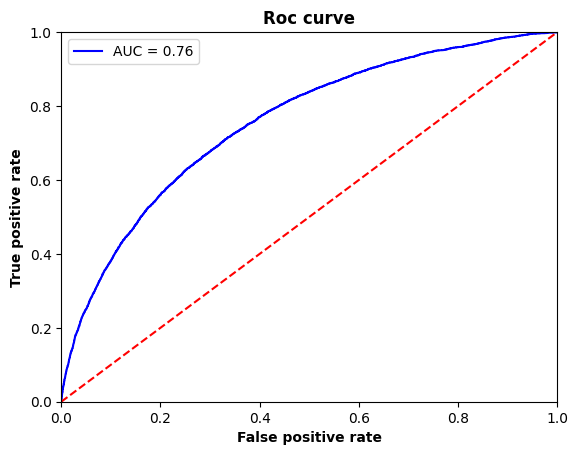

In [41]:
# Model evaluation
model_eval(lr_grid_search,X_val_scaled,y_val)

In [51]:
y_val_pred = lr_grid_search.predict(X_val_scaled)
# Confusion matrix on the validation data
conf_mat = confusion_matrix(y_val,y_val_pred)

tn = float(conf_mat[0][0])
fn = float(conf_mat[1][0])
tp = float(conf_mat[1][1])
fp = float(conf_mat[0][1])

# Afféctation subjective des coéfficients du score métier : fn = 10*fp
score_metier = round(metric_metier(tn,fp,fn,tp,1,-10,-100,0),3)
score_metier

0.565

# 3. Modèle d'ensemble : 

- Les arbres de décision fonctionnent souvent bien sur des données déséquilibrées. En machine learning moderne, les modèles d'ensembles(Random Forests, Gradient Boosted Trees, etc.) sont presque toujours plus performants que les arbres de décision singuliers. Nous allons donc nous y attaquer directement.

## 3.1. Random Forests Classifier

Confusion matrix :
 [[56532     5]
 [ 4952    13]]
Classification report :
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.72      0.00      0.01      4965

    accuracy                           0.92     61502
   macro avg       0.82      0.50      0.48     61502
weighted avg       0.90      0.92      0.88     61502


Accuracy : 0.919
Precision : 0.722
Recall : 0.00262
F1 score : 0.00522
ROCAUC score : 0.501
Fowlkes_Mallows score : 0.923



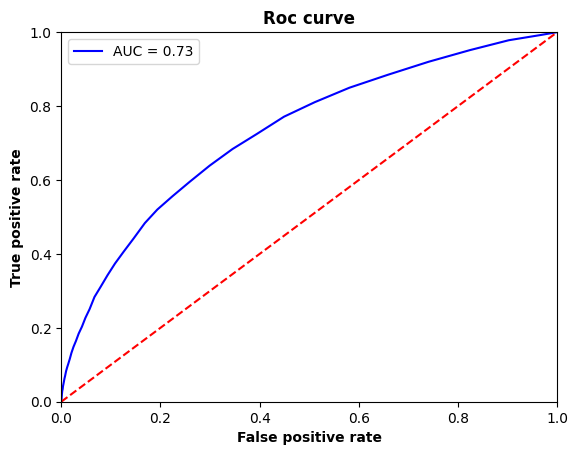

CPU times: total: 9min 56s
Wall time: 10min 35s


In [52]:
%%time
# RandomForestClassifier object
rf = RandomForestClassifier(random_state=42)
# fit the predictor and target
rf.fit(X_train_scaled,y_train)

# Model evaluation
model_eval(rf,X_val_scaled,y_val)

In [53]:
y_val_pred = rf.predict(X_val_scaled)
# Confusion matrix on the validation data
conf_mat = confusion_matrix(y_val,y_val_pred)

tn = float(conf_mat[0][0])
fn = float(conf_mat[1][0])
tp = float(conf_mat[1][1])
fp = float(conf_mat[0][1])

# Afféctation subjective des coéfficients du score métier : fn = 10*fp
score_metier = round(metric_metier(tn,fp,fn,tp,1,-10,-100,0),3)
score_metier

0.557

## 3.2. RandomForestClassifier avec SMOTE

Confusion matrix :
 [[55972   565]
 [ 4711   254]]
Classification report :
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     56537
           1       0.31      0.05      0.09      4965

    accuracy                           0.91     61502
   macro avg       0.62      0.52      0.52     61502
weighted avg       0.87      0.91      0.88     61502


Accuracy : 0.914
Precision : 0.31
Recall : 0.0512
F1 score : 0.0878
ROCAUC score : 0.521
Fowlkes_Mallows score : 0.916



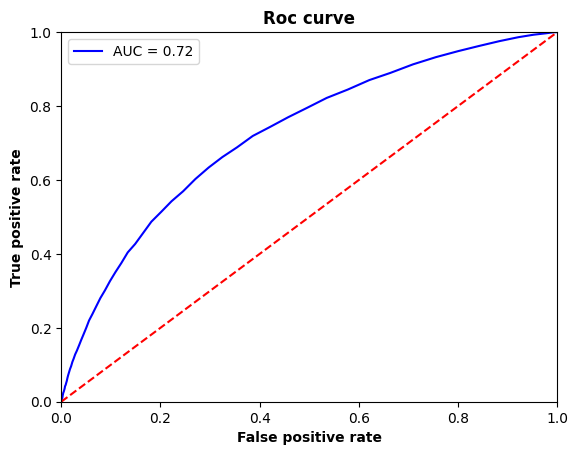

CPU times: total: 18min 25s
Wall time: 19min 23s


In [54]:
%%time
# Avec SMOTE
# RandomForestClassifier object
rfc_smote = RandomForestClassifier(random_state=42)
# fit the predictor and target
rfc_smote.fit(X_smote,y_smote)

# Model evaluation
model_eval(rfc_smote,X_val_scaled,y_val)

In [55]:
y_val_pred = rfc_smote.predict(X_val_scaled)
# Confusion matrix on the validation data
conf_mat = confusion_matrix(y_val,y_val_pred)

tn = float(conf_mat[0][0])
fn = float(conf_mat[1][0])
tp = float(conf_mat[1][1])
fp = float(conf_mat[0][1])

# Afféctation subjective des coéfficients du score métier : fn = 10*fp (heuristic)
score_metier = round(metric_metier(tn,fp,fn,tp,1,-10,-100,0),3)
score_metier

0.573

## 3.3. RandomForestClassifier avec RandomUnderSampler

Confusion matrix :
 [[39872 16665]
 [ 1648  3317]]
Classification report :
               precision    recall  f1-score   support

           0       0.96      0.71      0.81     56537
           1       0.17      0.67      0.27      4965

    accuracy                           0.70     61502
   macro avg       0.56      0.69      0.54     61502
weighted avg       0.90      0.70      0.77     61502


Accuracy : 0.702
Precision : 0.166
Recall : 0.668
F1 score : 0.266
ROCAUC score : 0.687
Fowlkes_Mallows score : 0.719



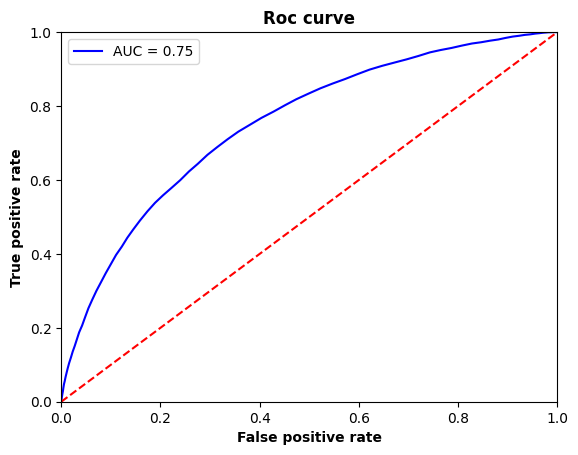

CPU times: total: 36.1 s
Wall time: 39.6 s


In [56]:
%%time
# Avec RandomUnderSampler
# RandomForestClassifier object
rfc_under_sampled = RandomForestClassifier(random_state=42)
# fit the predictor and target
rfc_under_sampled.fit(X_under_sampled,y_under_sampled)

# Model evaluation
model_eval(rfc_under_sampled,X_val_scaled,y_val)

In [57]:
y_val_pred = rfc_under_sampled.predict(X_val_scaled)
# Confusion matrix on the validation data
conf_mat = confusion_matrix(y_val,y_val_pred)

tn = float(conf_mat[0][0])
fn = float(conf_mat[1][0])
tp = float(conf_mat[1][1])
fp = float(conf_mat[0][1])

# Afféctation subjective des coéfficients du score métier : fn = 10*fp
score_metier = round(metric_metier(tn,fp,fn,tp,1,-10,-100,0),3)
score_metier

0.689

## 3.4. Random Forests Classifier avec GridSearchCV

In [36]:
%%time
# parameters
parameters = {
              "n_estimators" : [100,200,300], 
              "max_depth":[10,20]
}

rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(class_weight="balanced",random_state=42),
                              param_grid=parameters,scoring="roc_auc",cv=5)
# Fit the GridSearchCV model
rf_grid_search.fit(X_train_scaled,y_train)

CPU times: total: 30min 15s
Wall time: 30min 39s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [20, 30], 'n_estimators': [20, 50, 100]},
             scoring='roc_auc')

In [37]:
# Print best parameters and best score
print("Best Parameters:", rf_grid_search.best_params_)
print("Best Score:", rf_grid_search.best_score_)

Best Parameters: {'max_depth': 20, 'n_estimators': 100}
Best Score: 0.7454037513353643


In [38]:
# print winning set of hyperparameters
from pprint import pprint
pprint(rf_grid_search.best_estimator_.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Confusion matrix :
 [[55155  1382]
 [ 4253   712]]
Classification report :
               precision    recall  f1-score   support

           0       0.93      0.98      0.95     56537
           1       0.34      0.14      0.20      4965

    accuracy                           0.91     61502
   macro avg       0.63      0.56      0.58     61502
weighted avg       0.88      0.91      0.89     61502


Accuracy : 0.908
Precision : 0.34
Recall : 0.143
F1 score : 0.202
ROCAUC score : 0.559
Fowlkes_Mallows score : 0.908



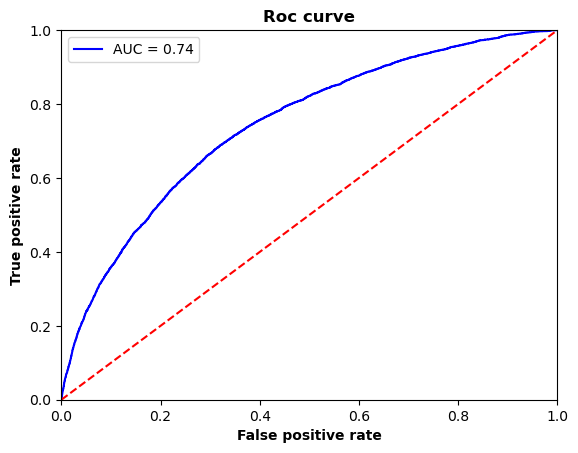

In [39]:
# Model evaluation
model_eval(rf_grid_search,X_val_scaled,y_val)

## 3.5. LGBMClassifier

Algorithme basé sur les arbres de décisions avec la particularité de développer l'arbre verticalement. Donc feuilles par feuilles au lieu de niveau par niveau. Il a pour avantage de converger plus rapidement.

In [23]:
%%time
# LGBMClassifier object
lgbmc = LGBMClassifier(is_unbalance=True,random_state=42)
# fit the predictor and target
lgbmc.fit(X_train_scaled,y_train,eval_set=[(X_train, y_train),(X_val, y_val)],eval_metric="auc")

[LightGBM] [Info] Number of positive: 19859, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19008
[LightGBM] [Info] Number of data points in the train set: 246004, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080726 -> initscore=-2.432519
[LightGBM] [Info] Start training from score -2.432519
CPU times: total: 1min 22s
Wall time: 12.1 s


LGBMClassifier(is_unbalance=True, random_state=42)

Confusion matrix :
 [[40950 15587]
 [ 1544  3421]]
Classification report :
               precision    recall  f1-score   support

           0       0.96      0.72      0.83     56537
           1       0.18      0.69      0.29      4965

    accuracy                           0.72     61502
   macro avg       0.57      0.71      0.56     61502
weighted avg       0.90      0.72      0.78     61502


Accuracy : 0.721
Precision : 0.18
Recall : 0.689
F1 score : 0.285
ROCAUC score : 0.707
Fowlkes_Mallows score : 0.732



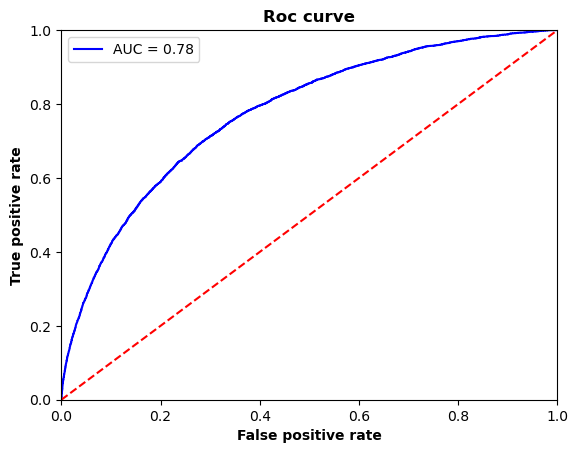

In [24]:
# Model evaluation
model_eval(lgbmc,X_val_scaled,y_val)

In [25]:
y_val_pred = lgbmc.predict(X_val_scaled)
# Confusion matrix on the validation data
conf_mat = confusion_matrix(y_val,y_val_pred)

tn = float(conf_mat[0][0])
fn = float(conf_mat[1][0])
tp = float(conf_mat[1][1])
fp = float(conf_mat[0][1])

# Afféctation subjective des coéfficients du score métier : fn = 10*fp
score_metier = round(metric_metier(tn,fp,fn,tp,1,-10,-100,0),3)
score_metier

0.709

## 3.6. LGBMClassifier avec GridSearchCV

In [42]:
%%time
# parameters
params = {   
            "max_depth":[10,20,30],
            "n_estimators" : [100,200,300], 
            "learning_rate": [0.1,0.01,0.001]
}


# GridSearchCV
lgbm_grid_search = GridSearchCV(estimator=LGBMClassifier(is_unbalance=True,objective="binary",
                                                         metric="auc",random_state=42),param_grid=params,cv=3)
# Fit the GridSearchCV model
lgbm_grid_search.fit(X_train_scaled,y_train)

[LightGBM] [Info] Number of positive: 13239, number of negative: 150763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18896
[LightGBM] [Info] Number of data points in the train set: 164002, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080725 -> initscore=-2.432542
[LightGBM] [Info] Start training from score -2.432542
[LightGBM] [Info] Number of positive: 13240, number of negative: 150763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18908
[LightGBM] [Info] Number of data points in the train set: 164003, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432467
[LightGBM] [Info] Start training from score -2.432467
[Lig

GridSearchCV(cv=3,
             estimator=LGBMClassifier(is_unbalance=True, metric='auc',
                                      objective='binary', random_state=42),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [10, 20, 30],
                         'n_estimators': [100, 200, 300]})

[LightGBM] [Info] Number of positive: 13240, number of negative: 150763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18908
[LightGBM] [Info] Number of data points in the train set: 164003, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432467
[LightGBM] [Info] Start training from score -2.432467
[LightGBM] [Info] Number of positive: 13239, number of negative: 150764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18907
[LightGBM] [Info] Number of data points in the train set: 164003, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080724 -> initscore=-2.432549
[LightGBM] [Info] Start training from score -2.432549
[Lig

[LightGBM] [Info] Number of positive: 13239, number of negative: 150763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18896
[LightGBM] [Info] Number of data points in the train set: 164002, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080725 -> initscore=-2.432542
[LightGBM] [Info] Start training from score -2.432542
[LightGBM] [Info] Number of positive: 13240, number of negative: 150763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18908
[LightGBM] [Info] Number of data points in the train set: 164003, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432467
[LightGBM] [Info] Start training from score -2.432467
[Lig

[LightGBM] [Info] Number of positive: 13239, number of negative: 150764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18907
[LightGBM] [Info] Number of data points in the train set: 164003, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080724 -> initscore=-2.432549
[LightGBM] [Info] Start training from score -2.432549
[LightGBM] [Info] Number of positive: 13239, number of negative: 150763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18896
[LightGBM] [Info] Number of data points in the train set: 164002, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080725 -> initscore=-2.432542
[LightGBM] [Info] Start training from score -2.432542
[Lig

GridSearchCV(cv=3,
             estimator=LGBMClassifier(is_unbalance=True, metric='auc',
                                      objective='binary', random_state=42),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [10, 20, 30],
                         'n_estimators': [100, 200, 300]})

In [45]:
# Print best parameters and best score
print("Best Parameters:", lgbm_grid_search.best_params_)
print("Best Score:", lgbm_grid_search.best_score_)

Best Parameters: {'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 100}
Best Score: 0.9192736703606798


In [44]:
# print winning set of hyperparameters
from pprint import pprint
pprint(lgbm_grid_search.best_estimator_.get_params())

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'is_unbalance': True,
 'learning_rate': 0.001,
 'max_depth': 10,
 'metric': 'auc',
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}


Confusion matrix :
 [[56537     0]
 [ 4965     0]]
Classification report :
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.46      0.50      0.48     61502
weighted avg       0.85      0.92      0.88     61502


Accuracy : 0.919
Precision : 0.0
Recall : 0.0
F1 score : 0.0
ROCAUC score : 0.5
Fowlkes_Mallows score : 0.923



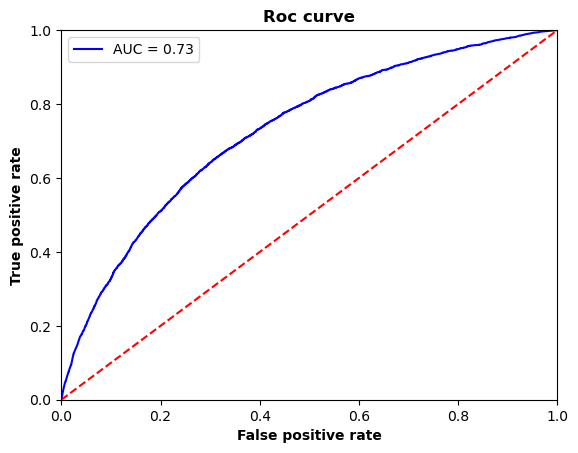

In [47]:
# Model evaluation
model_eval(lgbm_grid_search.best_estimator_,X_val_scaled,y_val)

##  Optimisation du seuil qui détermine la classe 0 ou 1.


**Bilan de la modélisation**
- Le modèle LGBMClassifier donne le meilleur score AUC et son rapport de classification nous indique qu'il réussit mieux à classer les éléments de la classe minoritaire malgré le déséquilibre des classes. Son score métier que nous avons construit est également le plus élevé. Cette valeur du score métier permet donc de dire que c'est avec le modèle LGBMClassifier que la Banque peut minimiser le risque de perte d'argent s'il décide d'accorder un prêt. Le modèle LGBMClassifier semble donc sortir du lot.
- Nous allons donc partir de ce modèle pour optimiser le seuil qui détermine, à partir d'une probabilité, la classe 0 ou 1.
- Nous avons affecté, en premier lieu, de manière subjective des coéfficients du score métier tout en considérant que le coût d'un FN est dix fois supérieur au coût d'un FP. Ces coefficients ne sont peut-être pas optimaux. Recalculons donc le score métier avec le modèle LGBMClassifier pour différents seuils de probabilité en variant l'ordre de grandeur du coefficient FN afin de l'optimiser.

In [26]:
# LGBM model predict proba
predicted_proba = lgbmc.predict_proba(X_val_scaled)
# LGBM model predict proba for class 1
predicted_proba_default = predicted_proba[:, 1]

In [27]:
# threshold
threshold_values = np.arange(0, 1.01, 0.01)
# Set some FN coefficients
coef_fn = [-10,-100,-1000]
# Business scores per FN coefficients 
score_metier_FN_10 = []
score_metier_FN_100 = []
score_metier_FN_1000 = []
# 
score_metier_FN_coefs = [score_metier_FN_10,score_metier_FN_100,score_metier_FN_1000]

for i, liste in enumerate(score_metier_FN_coefs):
    for threshold in threshold_values:
      # Predicted class 
        y_seuil=[]
        for predict_proba in predicted_proba_default:
            if predict_proba >= threshold:
                y_seuil.append(1)
            elif predict_proba < threshold:
                y_seuil.append(0)
        # Confusion matrix  
        conf_mat = confusion_matrix(y_val,y_seuil)
        tn = float(conf_mat[0][0])
        fn = float(conf_mat[1][0])
        tp = float(conf_mat[1][1])
        fp = float(conf_mat[0][1])

        score_metier_FN_coefs[i].append(metric_metier(tn,fp,fn,tp,1,-10,coef_fn[i],0))

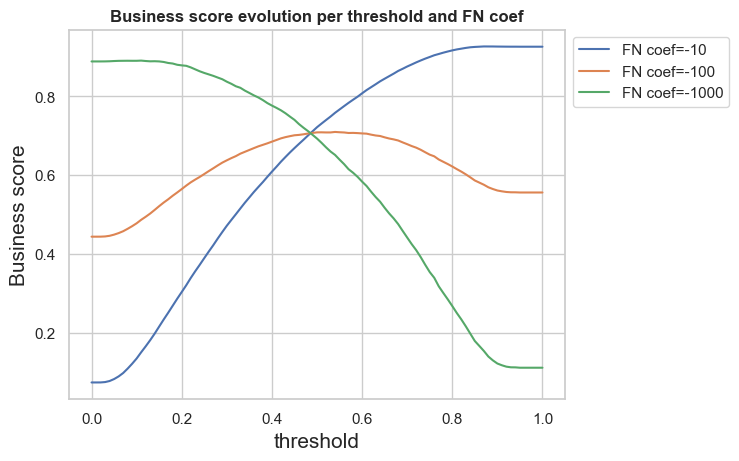

In [28]:
# Display of gain according to the solvency threshold
plt.figure()
# Setting seaborn style
sns.set(style="whitegrid")

plt.plot(threshold_values,score_metier_FN_10,label="FN coef=-10")
plt.plot(threshold_values,score_metier_FN_100,label="FN coef=-100")
plt.plot(threshold_values,score_metier_FN_1000,label="FN coef=-1000")
plt.xlabel("threshold",fontsize=15)
plt.ylabel("Business score",fontsize=15)
plt.title("Business score evolution per threshold and FN coef",fontweight="bold")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

La représentation ci-dessus témoigne de la pertinence du score métier. Nous pouvons remarquer que :
- Si coef_fn=-1000, le seuil optimal est de 0.2 et à partir de ce seuil la courbe décroit rapidement. Seuls les prêts avec une probabilité de défaut inférieur à 0,2% seront donc acceptés. Affecter donc aux FN un coefficient de -1000 va systématiquement réfuser la plupart des demandes de prêt.

- En revanche, pour coef_fn=-10, le seuil optimal pour que la banque ait le maximum de gain d'argent est autour de 0.9. La banque va donc systématiquement accorder toutes les demandes de prêt avec une probabilité de défaut < 0,9%. Ceci pose un vrai risque d'accepter quasiment tous demandeurs en défaut de payement.

- coef_fn=-100 est mieux adapté car le seuil optimal est autour de 0,6. Ce qui semble cohérent pour déterminer si oui ou non le prêt est accepté.

**Seuil optimal**

In [29]:
# Business scores for coef_fn=-100
score_metier_FN_100 = []
# threshold values
threshold_values = np.arange(0,1.01, 0.01)
for threshold in threshold_values:
    # Predicted class
    y_seuil=[]
    for predict_proba in predicted_proba_default:
        if predict_proba >= threshold:
            y_seuil.append(1)
        elif predict_proba < threshold:
            y_seuil.append(0)
    # Confusion matrix  
    conf_mat = confusion_matrix(y_val,y_seuil)
    tn = float(conf_mat[0][0])
    fn = float(conf_mat[1][0])
    tp = float(conf_mat[1][1])
    fp = float(conf_mat[0][1])  
    score_metier_FN_100.append(metric_metier(tn,fp,fn,tp,1,-10,-100,0))

# Searching the optimal threshold
threshold_values = pd.DataFrame({"threshold_values":threshold_values,"score_metier_FN_100":score_metier_FN_100})
optimal_threshold = threshold_values.loc[threshold_values["score_metier_FN_100"]==threshold_values["score_metier_FN_100"].max()]
display("The optimal threshold :",optimal_threshold)

'The optimal threshold :'

,threshold_values,score_metier_FN_100
54,0.54,0.709738


Conclusion :

Nous appliquons donc notre score métier pour un seuil optimal de 0.54 en affectant les coéfficients suivants : 
> $coef\_FN = -100 = 10*coef\_FP$ 

In [30]:
# LGBM model prediction
y_val_pred = lgbmc.predict(X_val_scaled)
y_val_pred

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [31]:
# Best threshold probability to determine positive class obtained with the business score
best_threshold = float(optimal_threshold["threshold_values"].values)

def predict_with_threshold(model, X, y):
    predicted_proba_default = model.predict_proba(X)[:,1]    
    return np.where(predicted_proba_default>best_threshold, 1, 0)

# Predict target values using the optimal threshold
y_val_pred_best_thres = predict_with_threshold(lgbmc,X_val_scaled, y_val)
y_val_pred_best_thres

array([0, 0, 0, ..., 0, 1, 1])

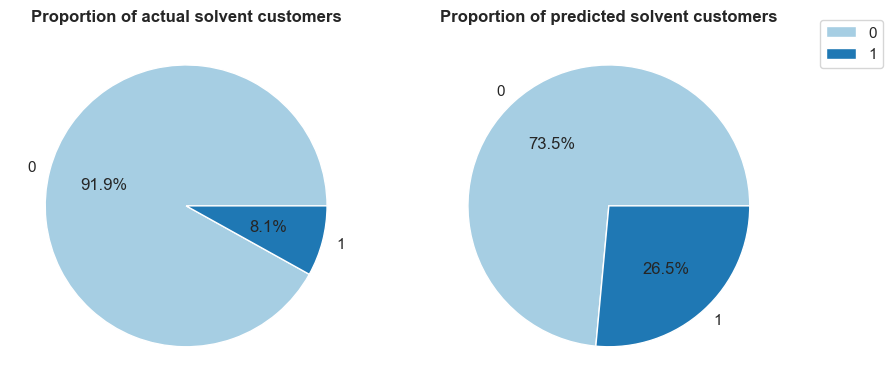

In [32]:
# Comparing the two situations 
comparison_data = pd.concat([pd.DataFrame(X_val_scaled), y_val.reset_index(drop=True)],axis=1)
comparison_data["predicted"] = y_val_pred_best_thres
   
fig,ax = plt.subplots(1,2,figsize=(10,6))
# Setting seaborn style
sns.set(style="whitegrid")
#  Colormap : 
colors = sns.color_palette("Paired",n_colors=2)

ax[0].set_title("Proportion of actual solvent customers",fontweight="bold")
ax[0].pie(comparison_data["TARGET"].value_counts(),labels=comparison_data["TARGET"].unique(),autopct="%.1f%%",colors=colors)
       
ax[1].set_title("Proportion of predicted solvent customers",fontweight="bold")
ax[1].pie(comparison_data["predicted"].value_counts(),labels=comparison_data["predicted"].unique(),autopct="%.1f%%",
          colors=colors)

plt.legend(bbox_to_anchor=(1.3,1.05))
plt.show()

* La prédiction avec le score métier au seuil optimal considère plus de personnes comme étant en défaut de payement comparé à la réalité, ce qui produit donc un manque à gagner pour la banque.
* Sa prédiction reste en revanche suffisamment bien pour ne pas risquer à prédire comme solvables des clients réellement en défaut de payement, ce qui nous évite le risque d'une perte en capital.

# II. Suivie de mes expérimentations avec MLflow

Chaque jour, le nombre d'outils permettant aux Data Scientists de créer des modèles plus rapidement augmente. Par conséquent, la nécessité de gérer 
les résultats et les modèles eux-mêmes devient évidente. MLflow répond à ce besoin avec ses capacités de suivi d'expériences, la prise en charge du 
packaging et son registre de modèles.

MLflow pourra nous permettre de confirmer de façon automatisée nos conclusions sur la comparaison des modèles vue ci-dessus grâce à MLflow UI. 

### Définir l'URI de suivi MLflow et une expérience MLflow

In [40]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
# Set the MLflow Experiment
mlflow.set_experiment("Home_credit_card_models")

<Experiment: artifact_location='mlflow-artifacts:/423939814221998651', creation_time=1738322600723, experiment_id='423939814221998651', last_update_time=1738322600723, lifecycle_stage='active', name='Home_credit_card_models', tags={}>

### Enregistrement des modèles et leurs hyperparamètres et métriques dans MLflow.

Nous lançons des runs afin d'enregistrer, lors de chaque run, le modèle et les hyperparamètre qui ont été utilisés lors de son ajustement, ainsi que les métriques associées à sa validation sur les données de réserve.

## 1. Log_reg avec feature scaling

In [17]:
# LogisticRegression object
lr_scale = LogisticRegression(random_state=42)
lr_scale.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [18]:
# Prediction
y_pred = lr_scale.predict(X_val_scaled)
report_dict = classification_report(y_val,y_pred,output_dict=True)
report_dict

{'0': {'precision': 0.9207504078303426,
  'recall': 0.9983196844544281,
  'f1-score': 0.9579673616945441,
  'support': 56537.0},
 '1': {'precision': 0.5297029702970297,
  'recall': 0.021550855991943604,
  'f1-score': 0.04141668279465841,
  'support': 4965.0},
 'accuracy': 0.9194660336249227,
 'macro avg': {'precision': 0.7252266890636861,
  'recall': 0.5099352702231859,
  'f1-score': 0.49969202224460124,
  'support': 61502.0},
 'weighted avg': {'precision': 0.8891815071872269,
  'recall': 0.9194660336249227,
  'f1-score': 0.8839750667978263,
  'support': 61502.0}}

In [19]:
y_val_pred = lr_scale.predict(X_val_scaled)
# Confusion matrix on the validation data
conf_mat = confusion_matrix(y_val,y_val_pred)

tn = float(conf_mat[0][0])
fn = float(conf_mat[1][0])
tp = float(conf_mat[1][1])
fp = float(conf_mat[0][1])

# Afféctation subjective des coéfficients du score métier : fn = 10*fp
score_metier = round(metric_metier(tn,fp,fn,tp,1,-10,-100,0),3)
score_metier

0.565

In [20]:
model_name = type(lr_scale).__name__ +"-scaled"
model_name

'LogisticRegression-scaled'

In [21]:
params = lr_scale.get_params()
params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [22]:
# ultra-quick setup for starting MLflow tracking
# mlflow.sklearn.autolog()

# First run
with mlflow.start_run(run_name="lr-scaled"):
    # Log parameters
    mlflow.log_params(params)
    mlflow.log_param("model_name",model_name)
    # log metrics
    mlflow.log_metrics({
        "accuracy": report_dict["accuracy"],
        "recall_class_0": report_dict["0"]["recall"],
        "recall_class_1": report_dict["1"]["recall"],
        "precision_macro": report_dict["macro avg"]["precision"],
        "f1_score_macro": report_dict["macro avg"]["f1-score"],
        "score_metier" : score_metier
    })
    # Set a tag that we can use to remind ourselves what this run was for
    # mlflow.set_tag("Training Info", "Basic LR model for home credit card")
    signature = infer_signature(X_train_scaled,y_train)
    # Log the model
    #mlflow.sklearn.log_model(pipe, "model", signature=signature)
    mlflow.sklearn.log_model(lr_scale,"lr_scaled",signature=signature)
    

🏃 View run lr-scaled at: http://127.0.0.1:5000/#/experiments/423939814221998651/runs/1e00cfb3dad042fbb5286cfa1ca0f184
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/423939814221998651


## 2. Log_reg avec RandomUnderSampler et feature scaling

In [23]:
# LogisticRegression object
lr_scale_under = LogisticRegression(random_state=42)
lr_scale_under.fit(X_under_sampled,y_under_sampled)

LogisticRegression(random_state=42)

In [24]:
# Prediction
y_val_pred = lr_scale_under.predict(X_val_scaled)
report_dict = classification_report(y_val,y_val_pred,output_dict=True)
report_dict

{'0': {'precision': 0.9616011680253073,
  'recall': 0.6989582043617454,
  'f1-score': 0.8095091773189118,
  'support': 56537.0},
 '1': {'precision': 0.16597246043024452,
  'recall': 0.6821752265861027,
  'f1-score': 0.2669872300173419,
  'support': 4965.0},
 'accuracy': 0.697603329973009,
 'macro avg': {'precision': 0.5637868142277759,
  'recall': 0.6905667154739241,
  'f1-score': 0.5382482036681269,
  'support': 61502.0},
 'weighted avg': {'precision': 0.8973707928633696,
  'recall': 0.697603329973009,
  'f1-score': 0.7657118785586715,
  'support': 61502.0}}

In [25]:
# Confusion matrix on the validation data
conf_mat = confusion_matrix(y_val,y_val_pred)

tn = float(conf_mat[0][0])
fn = float(conf_mat[1][0])
tp = float(conf_mat[1][1])
fp = float(conf_mat[0][1])

# Afféctation subjective des coéfficients du score métier : fn = 10*fp
score_metier = round(metric_metier(tn,fp,fn,tp,1,-10,-100,0),3)
score_metier

0.692

In [26]:
params = lr_scale_under.get_params()
params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [27]:
model_name = type(lr_scale_under).__name__ +"-under-scaled"
model_name

'LogisticRegression-under-scaled'

In [29]:
# ultra-quick setup for starting MLflow tracking
#mlflow.sklearn.autolog()
# Second run
with mlflow.start_run(run_name ="lr-under-scaled"):
    # Log parameters
    mlflow.log_params(params)
    mlflow.log_param("model_name",model_name)
    # log metrics
    mlflow.log_metrics({
        "accuracy": report_dict["accuracy"],
        "recall_class_0": report_dict["0"]["recall"],
        "recall_class_1": report_dict["1"]["recall"],
        "precision_macro": report_dict["macro avg"]["precision"],
        "f1_score_macro": report_dict["macro avg"]["f1-score"],
        "score_metier" : score_metier
    })
    # log model
    signature = infer_signature(X_under_sampled,y_under_sampled)
    mlflow.sklearn.log_model(lr_scale_under,"lr_under_scaled",signature=signature) 


🏃 View run lr-under-scaled at: http://127.0.0.1:5000/#/experiments/423939814221998651/runs/36a6a73589a14b2181ce39cdc41a5c18
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/423939814221998651


## 3. Log_reg avec SMOTE et feature scaling

In [30]:
# LogisticRegression object
lr_scale_smote = LogisticRegression(random_state=42)
lr_scale_smote.fit(X_smote,y_smote)

LogisticRegression(random_state=42)

In [31]:
# Prediction
y_val_pred = lr_scale_smote.predict(X_val_scaled)
report_dict = classification_report(y_val,y_val_pred,output_dict=True)
report_dict

{'0': {'precision': 0.9595971763798877,
  'recall': 0.7044944018961035,
  'f1-score': 0.8124923503733018,
  'support': 56537.0},
 '1': {'precision': 0.16444111027756939,
  'recall': 0.6622356495468278,
  'f1-score': 0.26346153846153847,
  'support': 4965.0},
 'accuracy': 0.7010828916132809,
 'macro avg': {'precision': 0.5620191433287286,
  'recall': 0.6833650257214656,
  'f1-score': 0.5379769444174202,
  'support': 61502.0},
 'weighted avg': {'precision': 0.8954049571317656,
  'recall': 0.7010828916132809,
  'f1-score': 0.7681695969483415,
  'support': 61502.0}}

In [32]:
# Confusion matrix on the validation data
conf_mat = confusion_matrix(y_val,y_val_pred)

tn = float(conf_mat[0][0])
fn = float(conf_mat[1][0])
tp = float(conf_mat[1][1])
fp = float(conf_mat[0][1])

# Afféctation subjective des coéfficients du score métier : fn = 10*fp
score_metier = round(metric_metier(tn,fp,fn,tp,1,-10,-100,0),3)
score_metier

0.686

In [33]:
model_name = type(lr_scale_smote).__name__ +"-smote-scaled"
model_name

'LogisticRegression-smote-scaled'

In [34]:
params = lr_scale_smote.get_params()
params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [35]:
# ultra-quick setup for starting MLflow tracking
# mlflow.sklearn.autolog()
# Third run
with mlflow.start_run(run_name ="lr-smote-scaled"):
    # Log parameters
    mlflow.log_params(params)
    mlflow.log_param("model_name",model_name)
    # log metrics
    mlflow.log_metrics({
        "accuracy": report_dict["accuracy"],
        "recall_class_0": report_dict["0"]["recall"],
        "recall_class_1": report_dict["1"]["recall"],
        "precision_macro": report_dict["macro avg"]["precision"],
        "f1_score_macro": report_dict["macro avg"]["f1-score"],
        "score_metier" : score_metier
    })
    # log model
    signature = infer_signature(X_smote,y_smote)
    mlflow.sklearn.log_model(lr_scale_smote,"lr_smote_scaled",signature=signature) 

🏃 View run lr-smote-scaled at: http://127.0.0.1:5000/#/experiments/423939814221998651/runs/b97dd0ac2026475993c51233dd251a61
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/423939814221998651


## 4. Log_reg avec GridSearchCV

In [55]:
# GridSearchCV with Lr
parameters = {
                'penalty':['l1','l2'], 
                'C':[0.5,1,1.5,10]
    }

lr_grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42),param_grid=parameters,scoring="roc_auc",cv=5)
lr_grid_search.fit(X_train_scaled,y_train) 

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.5, 1, 1.5, 10], 'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [56]:
# Prediction
y_val_pred = lr_grid_search.predict(X_val_scaled)
report_dict = classification_report(y_val,y_val_pred,output_dict=True)
report_dict

{'0': {'precision': 0.9207203680140942,
  'recall': 0.9983196844544281,
  'f1-score': 0.9579511027758213,
  'support': 56537.0},
 '1': {'precision': 0.525,
  'recall': 0.021148036253776436,
  'f1-score': 0.04065827686350436,
  'support': 4965.0},
 'accuracy': 0.9194335143572566,
 'macro avg': {'precision': 0.7228601840070471,
  'recall': 0.5097338603541023,
  'f1-score': 0.4993046898196628,
  'support': 61502.0},
 'weighted avg': {'precision': 0.8887742259831037,
  'recall': 0.9194335143572566,
  'f1-score': 0.883898895032095,
  'support': 61502.0}}

In [57]:
# Confusion matrix on the validation data
conf_mat = confusion_matrix(y_val,y_val_pred)

tn = float(conf_mat[0][0])
fn = float(conf_mat[1][0])
tp = float(conf_mat[1][1])
fp = float(conf_mat[0][1])

# Afféctation subjective des coéfficients du score métier : fn = 10*fp
score_metier = round(metric_metier(tn,fp,fn,tp,1,-10,-100,0),3)
score_metier

0.565

In [61]:
model_name = type(lr_grid_search).__name__ +"-lr-scaled"
model_name

'GridSearchCV-lr-scaled'

In [62]:
params = lr_grid_search.get_params()
params

{'cv': 5,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'deprecated',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': 42,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(random_state=42),
 'n_jobs': None,
 'param_grid': {'penalty': ['l1', 'l2'], 'C': [0.5, 1, 1.5, 10]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'roc_auc',
 'verbose': 0}

In [63]:
# Fourth run
with mlflow.start_run(run_name ="lr-gs-scaled"):
    # Log parameters
    mlflow.log_params(params)
    mlflow.log_param("model_name",model_name)
    # log metrics
    mlflow.log_metrics({
        "accuracy": report_dict["accuracy"],
        "recall_class_0": report_dict["0"]["recall"],
        "recall_class_1": report_dict["1"]["recall"],
        "precision_macro": report_dict["macro avg"]["precision"],
        "f1_score_macro": report_dict["macro avg"]["f1-score"],
        "score_metier" : score_metier
    })
    # log model
    signature = infer_signature(X_train_scaled,y_train)
    mlflow.sklearn.log_model(lr_grid_search,"lr_gs_scaled",signature=signature) 

🏃 View run lr-gs-scaled at: http://127.0.0.1:5000/#/experiments/423939814221998651/runs/b547da0816da41ea9d091ccdf51378b6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/423939814221998651


## 5. RandomForestClassifier avec SMOTE et feature scaling

In [36]:
# RandomForestClassifier object
rfc_scaled_smote = RandomForestClassifier(random_state=42)
# fit the predictor and target
rfc_scaled_smote.fit(X_smote,y_smote)

RandomForestClassifier(random_state=42)

In [37]:
# Prediction
y_val_pred = rfc_scaled_smote.predict(X_val_scaled)
report_dict = classification_report(y_val,y_val_pred,output_dict=True)
report_dict

{'0': {'precision': 0.922470910109767,
  'recall': 0.9899711693227444,
  'f1-score': 0.9550298180204929,
  'support': 56537.0},
 '1': {'precision': 0.31521739130434784,
  'recall': 0.05256797583081571,
  'f1-score': 0.09010875194199897,
  'support': 4965.0},
 'accuracy': 0.9142954700660141,
 'macro avg': {'precision': 0.6188441507070574,
  'recall': 0.5212695725767801,
  'f1-score': 0.522569284981246,
  'support': 61502.0},
 'weighted avg': {'precision': 0.8734478910068288,
  'recall': 0.9142954700660141,
  'f1-score': 0.8852055343698845,
  'support': 61502.0}}

In [38]:
# Confusion matrix on the validation data
conf_mat = confusion_matrix(y_val,y_val_pred)

tn = float(conf_mat[0][0])
fn = float(conf_mat[1][0])
tp = float(conf_mat[1][1])
fp = float(conf_mat[0][1])

# Afféctation subjective des coéfficients du score métier : fn = 10*fp
score_metier = round(metric_metier(tn,fp,fn,tp,1,-10,-100,0),3)
score_metier

0.574

In [39]:
model_name = type(rfc_scaled_smote).__name__ +"-smote-scaled"
model_name

'RandomForestClassifier-smote-scaled'

In [40]:
params = rfc_scaled_smote.get_params()
params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [41]:
# Fifth run
with mlflow.start_run(run_name ="rf-smote-scaled"):
    # Log parameters
    mlflow.log_params(params)
    mlflow.log_param("model_name",model_name)
    # log metrics
    mlflow.log_metrics({
        "accuracy": report_dict["accuracy"],
        "recall_class_0": report_dict["0"]["recall"],
        "recall_class_1": report_dict["1"]["recall"],
        "precision_macro": report_dict["macro avg"]["precision"],
        "f1_score_macro": report_dict["macro avg"]["f1-score"],
        "score_metier" : score_metier
    })
    # log model
    signature = infer_signature(X_smote,y_smote)
    mlflow.sklearn.log_model(rfc_scaled_smote,"rf_smote_scaled",signature=signature)     

🏃 View run rf-smote-scaled at: http://127.0.0.1:5000/#/experiments/423939814221998651/runs/3c4605986c7e446994b8fbb5005629c3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/423939814221998651


## 6. RandomForestClassifier avec RandomUnderSampler et feature scaling

In [42]:
# RandomForestClassifier object
rfc_scaled_under = RandomForestClassifier(random_state=42)
rfc_scaled_under.fit(X_under_sampled,y_under_sampled)

RandomForestClassifier(random_state=42)

In [43]:
# Prediction
y_val_pred = rfc_scaled_under.predict(X_val_scaled)
report_dict = classification_report(y_val,y_val_pred,output_dict=True)
report_dict

{'0': {'precision': 0.9603583642406435,
  'recall': 0.7053080283708014,
  'f1-score': 0.8133062747937466,
  'support': 56537.0},
 '1': {'precision': 0.16611611611611612,
  'recall': 0.668479355488419,
  'f1-score': 0.2661054319502906,
  'support': 4965.0},
 'accuracy': 0.7023348834184254,
 'macro avg': {'precision': 0.5632372401783798,
  'recall': 0.6868936919296103,
  'f1-score': 0.5397058533720186,
  'support': 61502.0},
 'weighted avg': {'precision': 0.8962399166789662,
  'recall': 0.7023348834184254,
  'f1-score': 0.7691312530917246,
  'support': 61502.0}}

In [44]:
# Confusion matrix on the validation data
conf_mat = confusion_matrix(y_val,y_val_pred)

tn = float(conf_mat[0][0])
fn = float(conf_mat[1][0])
tp = float(conf_mat[1][1])
fp = float(conf_mat[0][1])

# Afféctation subjective des coéfficients du score métier : fn = 10*fp
score_metier = round(metric_metier(tn,fp,fn,tp,1,-10,-100,0),3)
score_metier

0.689

In [45]:
params = rfc_scaled_under.get_params()
params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [46]:
model_name = type(rfc_scaled_under).__name__ +"-under-scaled"
model_name

'RandomForestClassifier-under-scaled'

In [47]:
# ultra-quick setup for starting MLflow tracking
#mlflow.sklearn.autolog()
# Sixth run
with mlflow.start_run(run_name ="rf-under-scaled"):
    # Log parameters
    mlflow.log_params(params)
    mlflow.log_param("model_name",model_name)
    # log metrics
    mlflow.log_metrics({
        "accuracy": report_dict["accuracy"],
        "recall_class_0": report_dict["0"]["recall"],
        "recall_class_1": report_dict["1"]["recall"],
        "precision_macro": report_dict["macro avg"]["precision"],
        "f1_score_macro": report_dict["macro avg"]["f1-score"],
        "score_metier" : score_metier
    })
    # log model
    signature = infer_signature(X_under_sampled,y_under_sampled)
    mlflow.sklearn.log_model(rfc_scaled_under,"rf_under_scaled",signature=signature)   

🏃 View run rf-under-scaled at: http://127.0.0.1:5000/#/experiments/423939814221998651/runs/d159822e9c6d488e8e6468d408c8309c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/423939814221998651


## 7. LGBMClassifier avec feature scaling

In [41]:
# LGBMClassifier object
lgbmc = LGBMClassifier(is_unbalance=True,random_state=42)
lgbmc.fit(X_train_scaled,y_train,eval_set=[(X_train, y_train),(X_val, y_val)],eval_metric="auc")

[LightGBM] [Info] Number of positive: 19859, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19008
[LightGBM] [Info] Number of data points in the train set: 246004, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080726 -> initscore=-2.432519
[LightGBM] [Info] Start training from score -2.432519


LGBMClassifier(is_unbalance=True, random_state=42)

In [42]:
# Prediction
y_val_pred = lgbmc.predict(X_val_scaled)
report_dict = classification_report(y_val,y_val_pred,output_dict=True)
report_dict

{'0': {'precision': 0.9636654586529863,
  'recall': 0.7243044378017935,
  'f1-score': 0.8270137633670265,
  'support': 56537.0},
 '1': {'precision': 0.17997685185185186,
  'recall': 0.6890231621349446,
  'f1-score': 0.2854044132982939,
  'support': 4965.0},
 'accuracy': 0.7214562128060876,
 'macro avg': {'precision': 0.5718211552524191,
  'recall': 0.7066637999683691,
  'f1-score': 0.5562090883326603,
  'support': 61502.0},
 'weighted avg': {'precision': 0.9003989968669041,
  'recall': 0.7214562128060876,
  'f1-score': 0.7832901377436117,
  'support': 61502.0}}

In [43]:
# Confusion matrix on the validation data
conf_mat = confusion_matrix(y_val,y_val_pred)

tn = float(conf_mat[0][0])
fn = float(conf_mat[1][0])
tp = float(conf_mat[1][1])
fp = float(conf_mat[0][1])

# Afféctation subjective des coéfficients du score métier : fn = 10*fp
score_metier = round(metric_metier(tn,fp,fn,tp,1,-10,-100,0),3)
score_metier

0.709

In [44]:
params = lgbmc.get_params()
params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'is_unbalance': True}

In [45]:
model_name = type(lgbmc).__name__+"-scaled"
model_name

'LGBMClassifier-scaled'

In [46]:
# ultra-quick setup for starting MLflow tracking
#mlflow.sklearn.autolog()
# Seventh run
with mlflow.start_run(run_name ="lgbm-scaled"):
    # Log parameters
    mlflow.log_params(params)
    mlflow.log_param("model_name",model_name)
    # log metrics
    mlflow.log_metrics({
        "accuracy": report_dict["accuracy"],
        "recall_class_0": report_dict["0"]["recall"],
        "recall_class_1": report_dict["1"]["recall"],
        "precision_macro": report_dict["macro avg"]["precision"],
        "f1_score_macro": report_dict["macro avg"]["f1-score"],
        "score_metier" : score_metier
    })
    # Infer the model signature
    signature = infer_signature(X_train_scaled,y_train)
    # log model
    mlflow.lightgbm.log_model(lgbmc,"lgbm_scaled",signature=signature)   

🏃 View run lgbm-scaled at: http://127.0.0.1:5000/#/experiments/423939814221998651/runs/b97fbe05eb834fb09016b64da09dbe2f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/423939814221998651


# III. Régistre et déploiement de modèle avec MLflow

Charger notre modèle enregistré en tant que fonction Python (pyfunc) et l'utiliser pour l'inférence.
Bien que nous puissions recharger notre modèle en tant que format scikit-learn natif avec mlflow.sklearn.load_model(), nous chargeons ci-dessous le modèle en tant que fonction Python générique, ce qui correspond à la manière dont ce modèle serait chargé pour la diffusion de modèles en ligne.

Differences Between Runs and Registered Models :
- Run-based models: Best suited for development and experimentation, allowing for quick iteration and debugging.
- Registered Models: Ideal for production, offering version control and lifecycle management, making it easier to manage and update models in a 
team environment.

### Register the model

In [47]:
model_name = "lgbm-scaled"
run_id=input("'Please type RunID")
model_uri = f"runs:/{run_id}/model_name"

with mlflow.start_run(run_id=run_id):
    mlflow.register_model(model_uri=model_uri, name=model_name)

'Please type RunIDb97fbe05eb834fb09016b64da09dbe2f


Registered model 'lgbm-scaled' already exists. Creating a new version of this model...
2025/02/12 19:02:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lgbm-scaled, version 3


🏃 View run lgbm-scaled at: http://127.0.0.1:5000/#/experiments/423939814221998651/runs/b97fbe05eb834fb09016b64da09dbe2f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/423939814221998651


Created version '3' of model 'lgbm-scaled'.


### Load the model for inference

In [51]:
# Predictions 
model_uri = 'runs:/b97fbe05eb834fb09016b64da09dbe2f/lgbm_scaled'

# Load the model back for predictions as a generic Python Function model(PyFuncModel)
loaded_model = mlflow.pyfunc.load_model(model_uri)

In [54]:
# Use our model to predict the class on a Pandas DataFrame.
y_val_pred = loaded_model.predict(X_val_scaled)
y_val_pred[:5]

array([0, 0, 0, 0, 1], dtype=int64)

# IV. Fetaure importance 

In [55]:
# Save the lgbm model
pickle.dump(lgbmc, open("best_model_lgbm.pickle","wb"))

In [56]:
# Load back the best model
with open("best_model_lgbm.pickle","rb") as f:
    # deserialize using load()
    best_model = pickle.load(f)     
best_model

LGBMClassifier(is_unbalance=True, random_state=42)

## IV.1. Importance globale des variables avec l'approche classique 

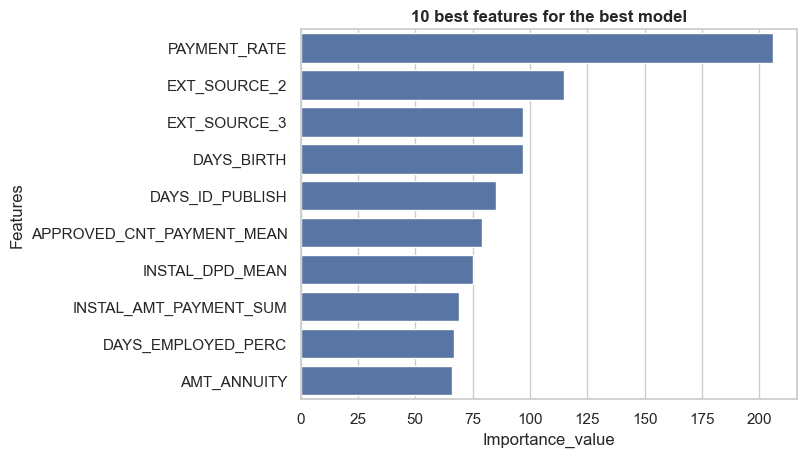

In [132]:
feature_importance = pd.DataFrame(sorted(zip(best_model.booster_.feature_importance(),
                                      X_val_scaled.columns)), columns=["Importance_value","Features"])

plt.figure()
sns.barplot(x="Importance_value",y="Features",data=feature_importance.sort_values(by="Importance_value",
                                                                                  ascending=False).head(10))
plt.title("10 best features for the best model",fontweight="bold")
plt.show()

## IV.2. Importance globale des variables avec SHAP 

In [98]:
# load JS visualization code to notebook
shap.initjs()

# Create the explainer
explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_val_scaled)

Variable Importance Plot - Global Interpretation


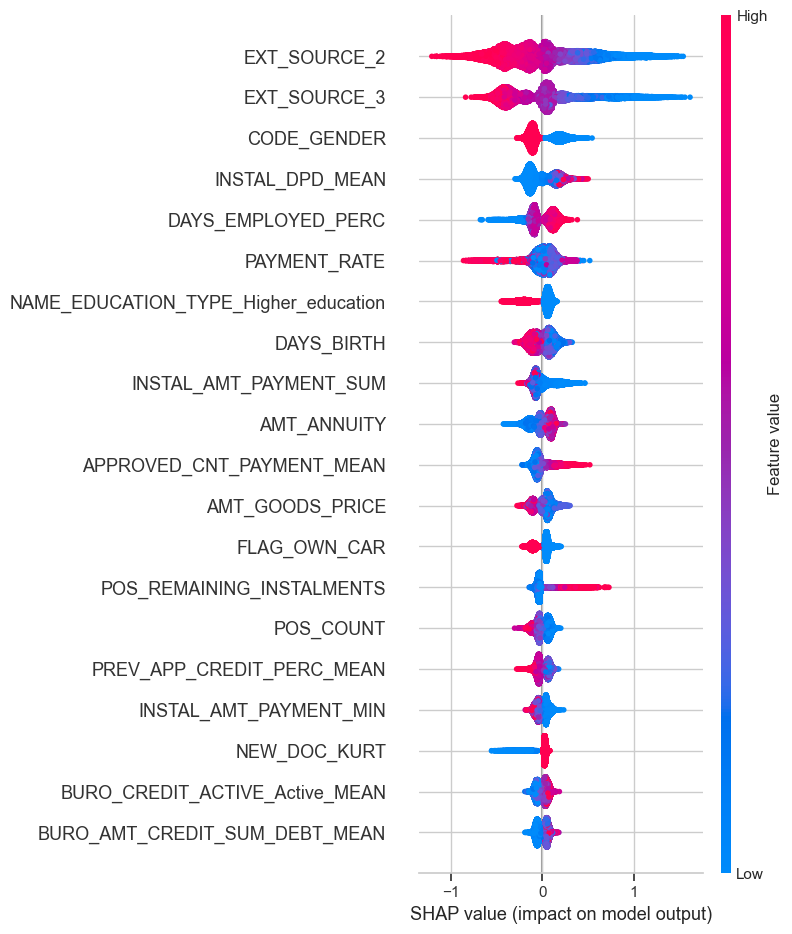

In [62]:
print("Variable Importance Plot - Global Interpretation")
#plot the feature importance
shap.summary_plot(shap_values, X_val_scaled)

**Interprétabilité globale**

- Importance des VARIABLES : les variables sont classées par ordre décroissant.
- Au lieu d'utiliser un graphique à barres d'importance des variables typiques, nous utilisons un nuage de points de la densité des valeurs SHAP pour chaque variable afin d'identifier l'impact de chacune d'elles sur la performance du modèle. Les variables sont triées par la somme des magnitudes SHAP sur tous les échantillons. Les quelques variable sorties par SHAP sont les plus pertinents ppour le modèle.
- Les variables EXT_SOURCE_2 et EXT_SOURCE_3 ont plus d'impact total sur le modèle que le reste, tandis que leurs faibles valeurs ont un impact plus positif que leurs valeurs élevées sur la prédiction de la classe de défaut de payement.
- Un client avec une faible valeur EXT_SOURCE_2 ou EXT_SOURCE_3 est susceptible d'être classée comme non solvable tandis qu'un client avec une grande valeur de PAYMENHT_RATE est quant à lui susceptible d'être solvable.

## IV.2. Importance locale des variables avec LIME

Au lieu de fournir une compréhension globale du modèle sur l'ensemble des données, LIME se concentre sur l'explication de la prédiction du modèle pour des instances individuelles.

In [118]:
# Get the class names
class_names = ['Sovable', 'No solvable']

# Get the feature names
feature_names = list(X_val_scaled.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer
lime_explainer = LimeTabularExplainer(X_val_scaled.values,feature_names=feature_names,
                                 class_names=class_names,mode ='classification')

lime_exp = lime_explainer.explain_instance(data_row=X_val_scaled.iloc[1],predict_fn=best_model.predict_proba)
lime_exp.show_in_notebook(show_table=True)

- Le modèle prédit bien qu'il s'agit d'un client solvable (68 % de chances). 
- Les variables en bleu augmentent les chances qu'un client soit classé comme solvable, tandis que celle en jaune font le contraire.

In [121]:
# LIME's' prediction probabilities for the cleint 1
lime_exp.predict_proba

array([0.67534345, 0.32465655])

### Sauvegarde du jeu de données avec les variables importantes selon SHAP

In [136]:
features = ['SK_ID_CURR','EXT_SOURCE_2','EXT_SOURCE_3','CODE_GENDER','INSTAL_DPD_MEAN','DAYS_EMPLOYED_PERC','PAYMENT_RATE',
             'NAME_EDUCATION_TYPE_Higher_education','DAYS_BIRTH','INSTAL_AMT_PAYMENT_SUM','AMT_ANNUITY',
         'APPROVED_CNT_PAYMENT_MEAN','AMT_GOODS_PRICE','FLAG_OWN_CAR','POS_REMAINING_INSTALMENTS','POS_COUNT',
         'PREV_APP_CREDIT_PERC_MEAN','INSTAL_AMT_PAYMENT_MIN','NEW_DOC_KURT','BURO_CREDIT_ACTIVE_Active_MEAN',
            'BURO_AMT_CREDIT_SUM_DEBT_MEAN']
data_best_features = X_val_scaled[features]
data_best_features

,SK_ID_CURR,EXT_SOURCE_2,EXT_SOURCE_3,CODE_GENDER,INSTAL_DPD_MEAN,DAYS_EMPLOYED_PERC,PAYMENT_RATE,NAME_EDUCATION_TYPE_Higher_education,DAYS_BIRTH,INSTAL_AMT_PAYMENT_SUM,...,APPROVED_CNT_PAYMENT_MEAN,AMT_GOODS_PRICE,FLAG_OWN_CAR,POS_REMAINING_INSTALMENTS,POS_COUNT,PREV_APP_CREDIT_PERC_MEAN,INSTAL_AMT_PAYMENT_MIN,NEW_DOC_KURT,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MEAN
0,0.301127,1.249605,0.001294,-1.387506,-0.123984,1.198269,2.904812,-0.566873,0.828789,-0.587881,...,-0.491076,-0.238358,1.393139,-0.536332,-0.785494,0.347958,0.713922,0.365102,-0.000591,-0.000590
1,0.367517,0.802163,-0.714685,-1.387506,-0.051562,-0.696824,-0.320517,-0.566873,-1.223329,-0.598994,...,-0.354719,0.286456,1.393139,0.239799,0.359284,0.353845,-0.355800,0.365102,-0.571675,-0.256992
2,-0.566233,-0.359908,-1.828261,0.720718,-0.021919,0.625865,-0.656092,1.764064,-0.798516,1.357618,...,4.690489,-0.226153,-0.717803,0.412272,0.316885,-0.125980,-0.353920,0.365102,0.304530,5.416520
3,-0.232561,-0.841867,1.487268,0.720718,-0.103822,0.596113,-1.089487,-0.566873,0.685122,-0.409116,...,-0.854872,1.470341,-0.717803,-0.536332,-0.319103,0.074192,-0.360668,0.365102,-0.571675,-0.336201
4,0.653933,-1.259905,-0.616696,0.720718,0.106304,-2.519239,-0.108574,-0.566873,0.459197,-0.420251,...,-0.218362,0.042357,-0.717803,-0.450095,1.122470,-0.108318,-0.363466,0.365102,0.109437,-0.106503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61497,-1.550869,0.449323,-0.714685,0.720718,-0.123984,0.001083,-0.912869,-0.566873,1.115664,-0.556754,...,0.054352,0.493941,-0.717803,-0.450095,-0.276703,0.524580,-0.011656,0.365102,-0.571675,-0.235985
61498,1.585447,1.029719,-2.379099,-1.387506,-0.079006,0.745376,-1.089487,1.764064,0.401684,-0.713620,...,-1.036504,2.080591,1.393139,-0.536332,-0.658296,0.930812,-0.350773,0.365102,-0.446747,-0.215926
61499,1.491771,-0.450675,0.605367,0.720718,0.000647,-1.089142,-1.216517,1.764064,-1.314524,-0.000417,...,-0.001161,2.202641,-0.717803,-0.000802,-0.000424,0.000619,0.000675,0.365102,-0.571675,-0.279084
61500,-1.207566,-1.842219,0.001294,-1.387506,-0.123984,1.022974,-0.279759,-0.566873,-1.643101,-0.722110,...,-1.036504,-1.178143,-0.717803,-0.018911,-0.955091,0.312633,0.028061,0.365102,-0.000591,-0.000590


In [138]:
# Save data 
data_best_features.to_csv("data_best_features.csv")